In [1]:
import json

def load_json_file(file_path):
    """Load a JSON file and return its contents."""
    with open(file_path, 'r') as file:
        return json.load(file)

In [64]:
def find_common_groups(mitre_file, malpedia_file, intersection_file, data_type = 'cves'):
    """
    Find groups present in both MITRE and Malpedia CVE/TTP files based on names and aliases, 
    and also list groups not found in Malpedia.
    
    Returns:
        common_groups (dict): Groups found in both MITRE and Malpedia.
        not_in_malpedia (dict): Groups found in MITRE but not in Malpedia.
    """
    common_groups = {}
    not_in_malpedia = {}
    data_label = "CVEs" if data_type == "cves" else "TTPs"

    for group_id, mitre_data in mitre_file.items():
        mitre_group_name = intersection_file.get(group_id, {}).get("MITRE Group Name", "").lower()
        mitre_aliases = set(alias.lower() for alias in intersection_file.get(group_id, {}).get("MITRE Associated Names", []))
        malpedia_actor_name = intersection_file.get(group_id, {}).get("Malpedia Actor Name", "").lower()
        malpedia_aliases = set(alias.lower() for alias in intersection_file.get(group_id, {}).get("Malpedia Aliases", []))

        # Flag to indicate if a match is found
        found_in_malpedia = False

        # Search in the Malpedia CVE file by matching names and aliases
        for malpedia_group, malpedia_data in malpedia_file.items():
            malpedia_group_name = malpedia_group.lower()

            # Check if the MITRE group or aliases match the Malpedia group or aliases
            if (mitre_group_name == malpedia_group_name or
                malpedia_group_name in mitre_aliases or
                malpedia_actor_name == malpedia_group_name or
                malpedia_group_name in malpedia_aliases):
                
                # If match found, save the group details in common_groups
                common_groups[group_id] = {
                    "MITRE Group Name": mitre_group_name,
                    f"MITRE {data_label}": mitre_data.get("hashes", []),
                    "Malpedia Group Name": malpedia_group_name,
                    f"Malpedia {data_label}": malpedia_data.get("hashes", []),
                    "MITRE URL": mitre_data.get("url"),
                    "Malpedia URL": malpedia_data.get("url")
                }
                                
                found_in_malpedia = True
                break  # Stop searching once a match is found

        # If no match found, record it in not_in_malpedia
        if not found_in_malpedia:
            not_in_malpedia[group_id] = {
                "MITRE Group Name": mitre_group_name,
                f"MITRE {data_label}": mitre_data.get("hashes", []),
                "MITRE URL": mitre_data.get("url")
            }

    return common_groups, not_in_malpedia

In [67]:
# Load the files
#mitre_cve_file = load_json_file('MITRE_cves_group_analysis.json')
#malpedia_cve_file = load_json_file('Malpedia_cve_group_analysis.json')

mitre_file = load_json_file('MITRE_ttps_group_analysis.json')
malpedia_file = load_json_file('Malpedia_ttps_group_analysis.json')

intersection_file = load_json_file('group_intersection_output.json')

# Find the common groups between MITRE and Malpedia
common_groups, not_in_malpedia = find_common_groups(mitre_file, malpedia_file, intersection_file, data_type = 'ttps')


print(f"Found {len(common_groups)} common groups.")


Found 56 common groups.


In [68]:
len(not_in_malpedia)

# Extracting group IDs and MITRE Group Names
group_id_and_name = [(group_id, not_in_malpedia[group_id]['MITRE Group Name']) for group_id in not_in_malpedia]

# Output the list of group IDs with their MITRE Group Names
for group_id, group_name in group_id_and_name:
    print(f"{group_id}: {group_name}")

G0108: 
G0120: evilnum
G1023: apt5
G0123: volatile cedar
G1015: scattered spider


In [73]:
def extract_identifiers(hashes, data_type):
    """Extract all CVEs or TTPs from a list of hashes based on data_type."""
    key = "cves" if data_type == "cves" else "ttps"
    identifiers = set()
    
    for entry in hashes:
        identifiers.update(entry.get(key, []))

    return identifiers


In [74]:

def calculate_statistics(common_groups, data_type):
    """Calculate unique CVEs/TTPs, union, and intersection per group."""
    stats = {}
    mitre_key = f"MITRE {'CVEs' if data_type == 'cves' else 'TTPs'}"
    malpedia_key = f"Malpedia {'CVEs' if data_type == 'cves' else 'TTPs'}"

    for group_id, group_data in common_groups.items():
        mitre_identifiers = extract_identifiers(group_data.get(mitre_key, []), data_type)
        malpedia_identifiers = extract_identifiers(group_data.get(malpedia_key, []), data_type)

        # Calculate statistics
        unique_mitre = mitre_identifiers - malpedia_identifiers
        unique_malpedia = malpedia_identifiers - mitre_identifiers
        identifier_union = mitre_identifiers | malpedia_identifiers  # Union
        identifier_intersection = mitre_identifiers & malpedia_identifiers  # Intersection

        # Store the statistics for this group
        stats[group_id] = {
            "MITRE Group Name": group_data.get("MITRE Group Name"),
            "Malpedia Group Name": group_data.get("Malpedia Group Name"),
            f"{data_type.upper()}s in MITRE": list(mitre_identifiers),
            f"{data_type.upper()}s in Malpedia": list(malpedia_identifiers),
            f"Count of Unique MITRE {data_type.upper()}s": len(unique_mitre),
            f"Count of Unique Malpedia {data_type.upper()}s": len(unique_malpedia),
            f"Count of Union {data_type.upper()}s": len(identifier_union),
            f"Count of Intersection {data_type.upper()}s": len(identifier_intersection),
        }

    return stats

In [75]:
#stats_cves = calculate_statistics(common_groups, "cves")
stats_ttps = calculate_statistics(common_groups, "ttps")


In [93]:
import pandas as pd
import matplotlib.pyplot as plt


def generate_agreement_table(common_groups, data_type):
    """Generate an agreement table comparing CVEs/TTPs between MITRE and Malpedia."""
    table_data = []
    mitre_key = f"MITRE {'CVEs' if data_type == 'cves' else 'TTPs'}"
    malpedia_key = f"Malpedia {'CVEs' if data_type == 'cves' else 'TTPs'}"

    for group_id, group_data in common_groups.items():
        mitre_identifiers = extract_identifiers(group_data.get(mitre_key, []), data_type)
        malpedia_identifiers = extract_identifiers(group_data.get(malpedia_key, []), data_type)

        # Compute unique and common identifiers
        unique_mitre = mitre_identifiers - malpedia_identifiers
        unique_malpedia = malpedia_identifiers - mitre_identifiers
        common_identifiers = mitre_identifiers & malpedia_identifiers
        total_identifiers = mitre_identifiers | malpedia_identifiers

        # Compute agreement percentage
        agreement_percentage = (len(common_identifiers) / len(total_identifiers) * 100) if total_identifiers else 0

        # Store data for table
        table_data.append({
            "Group Name": group_id,
            f"Unique MITRE {data_type.upper()}s": len(unique_mitre),
            f"Unique Malpedia {data_type.upper()}s": len(unique_malpedia),
            f"Common {data_type.upper()}s": len(common_identifiers),
            f"Total {data_type.upper()}s": len(total_identifiers),
            "% Agreement": round(agreement_percentage, 2)
        })

    # Convert to Pandas DataFrame
    df = pd.DataFrame(table_data)
    return df

def plot_scatter_agreement(df, data_type):
    """Plot a scatter plot of total CVEs/TTPs vs. % Agreement."""
    plt.figure(figsize=(8, 6))
    plt.scatter(df[f"Total {data_type.upper()}s"], df["% Agreement"], alpha=0.7, edgecolors='black')

    plt.xlabel(f"Total {data_type.upper()} per Group")
    plt.ylabel(f"% Agreement (MITRE vs Malpedia)")
    #plt.title(f"{data_type.upper()} Profile Agreement Across Threat Groups")
    plt.grid(True)
    
    save_path=f"{data_type}_scatter_plot.pdf"
    plt.savefig(save_path, format="pdf", bbox_inches="tight")

    plt.show()


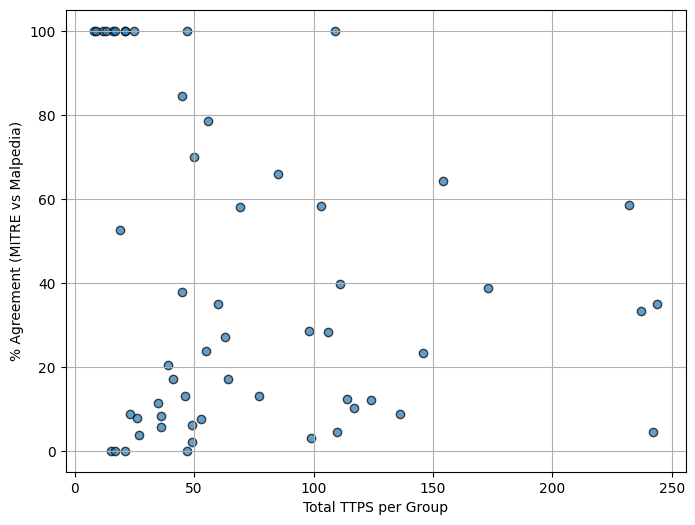

In [94]:
# Show all rows without truncation
pd.set_option('display.max_rows', None)


#df_cves = generate_agreement_table(common_groups, "cves")
df_ttps = generate_agreement_table(common_groups, "ttps")

#plot_scatter_agreement(df_cves, "cves")
plot_scatter_agreement(df_ttps, "ttps")



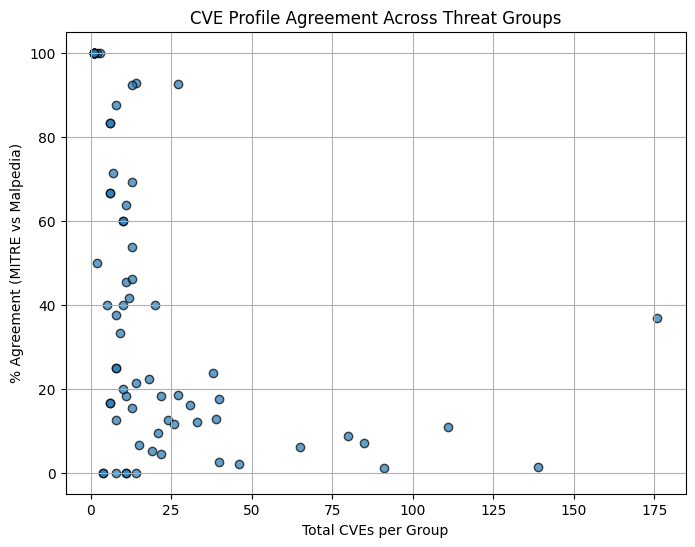

In [58]:
plot_scatter_agreement(agreement_df)  # Generates scatter plot

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_agreement_boxplot(stats, data_type):
    """
    Creates a box plot showing the distribution of agreement percentages between MITRE and Malpedia identifiers (CVEs or TTPs).
    
    Parameters
    ----------
    stats : dict
        A dictionary where each key is a threat group ID (e.g., 'G0068'), and values contain:
        - MITRE Group Name
        - Malpedia Group Name
        - Count of identifiers (CVEs or TTPs)
    data_type : str
        The type of data to plot. Either "cves" or "ttps".
    """
    key_intersection = f"Count of Intersection {data_type.upper()}s"
    key_union = f"Count of Union {data_type.upper()}s"
    
    # Extract the agreement percentages for either CVEs or TTPs
    agreement_percentages = [
        (data[key_intersection] / data[key_union] * 100 if data[key_union] > 0 else 0)
        for data in stats.values()
    ]
    
    # Create box plot
    plt.figure(figsize=(3, 6))
    sns.boxplot(data=agreement_percentages, color="lightblue")

    # Add titles and labels
    plt.ylabel(f"{data_type.upper()} Agreement (%)")
    #plt.title(f"{data_type.upper()} Agreement Percentage Distribution Between MITRE and Malpedia")

    # Save and show plot
    save_path = f"{data_type}_box_plot.pdf"
    plt.savefig(save_path, format="pdf", bbox_inches="tight")
    plt.show()



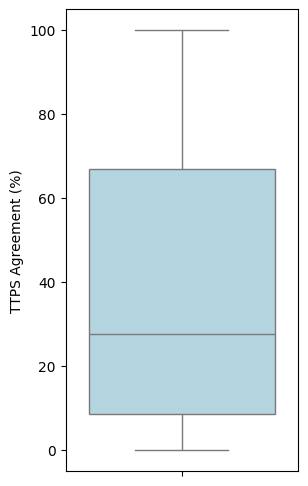

In [96]:
# Example usage:
#plot_agreement_boxplot(stats_cve, "cves")
plot_agreement_boxplot(stats_ttps, "ttps")
